# Thick Sample Ptychography Forward Model Tutorial 2D

This tutorial demonstrates how to use `thick_ptycho` to set up and solve a 2D forward problem with multiple probes, both iteratively and as a full system.


The forward model solves the paraxial equation:

\begin{equation}
\frac{\partial u}{\partial z} = a \frac{\partial^2 u}{\partial x^2}  + C(x, z) u,
\end{equation}
where
\begin{equation}
a := \frac{1}{2ik} \qquad \text{and} \qquad C(x, z) := \frac{k}{2i} \left(n^2(x, z) - 1\right)
\end{equation}


**$n$ defines the refractive index of the volume. $k$ is the wave number.**

### 1. Import Libraries: Sample Space and Forward Model


In [1]:
# from thick_ptycho.sample_space.sample_space import SampleSpace
# from thick_ptycho.forward_model.solver import ForwardModel
from thick_ptycho.simulation.config import SimulationConfig, BoundaryType, ProbeType
from thick_ptycho.simulation.simulation_space import create_simulation_space
from thick_ptycho.simulation.ptycho_object import create_ptycho_object
from thick_ptycho.simulation.ptycho_probe import create_ptycho_probes
from thick_ptycho.forward_model import ForwardModelPWEIterative, ForwardModelPWEFull, ForwardModelMS
from matplotlib import pyplot as plt


from thick_ptycho.reconstruction.ms_reconstructor import ReconstructorMS
from thick_ptycho.reconstruction.pwe_reconstructor import ReconstructorPWE

import numpy as np

### 2. Set Simulation Parameters

Choose boundary conditions, probe type, and define the spatial domain and discretization.

2025-10-29 17:20:37,057 - INFO - === Scan Summary (Continuous) ===
2025-10-29 17:20:37,061 - INFO -   Sample space (x-range): 5.000e-05 m
2025-10-29 17:20:37,063 - INFO -   Sample space (z-range): 5.000e-05 m
2025-10-29 17:20:37,064 - INFO -   Probe diameter:         1.000e-06 m
2025-10-29 17:20:37,066 - INFO -   Number of scan points:  20
2025-10-29 17:20:37,067 - INFO -   Steps in z:             115
2025-10-29 17:20:37,069 - INFO -   Detector Pixels:        115
2025-10-29 17:20:37,071 - INFO -   Max Overlap:            -3.158e-07 m
2025-10-29 17:20:37,072 - INFO -   Percentage Overlap:     -72000000.00%



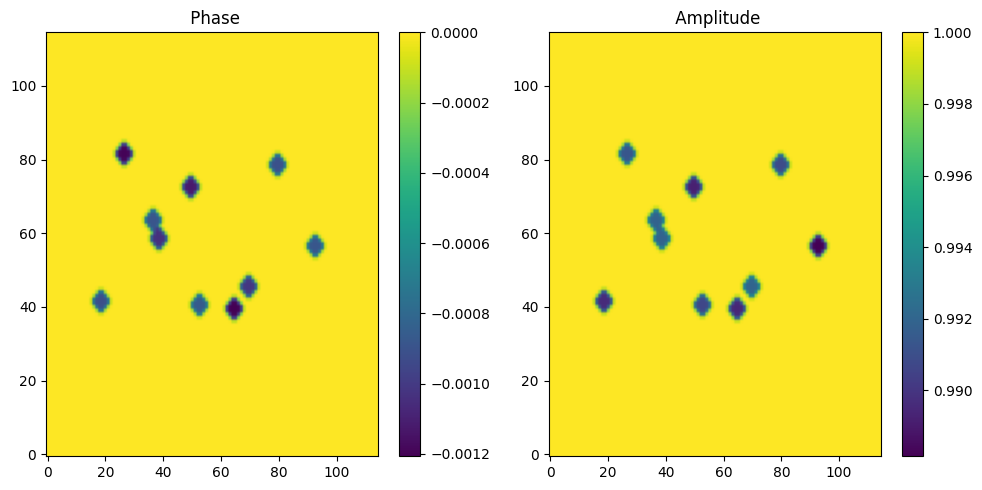

In [ ]:
wavelength = 0.635e-6        # meters (0.635 μm)
k0 = 2 * np.pi / wavelength  # wavenumber [1/m]

# --- Refractive index parameters ---
n_medium = 1.0               # background refractive index

# --- Probe configuration ---
probe_dimensions_discrete = [20]
probe_diameter_scale = 0.02
probe_focus = -5e-6                    # focal length [m]
scan_points = 20#124
step_size = 3                        # pixels between scans

pad_factor = 1.5  # Portion of extra space to add
# Define margin portion (half of extra space)
pad_margin = (pad_factor - 1) / 2.0

# --- Simulation spatial dimensions (in meters) ---
xlims = [0.0, 50e-6]   # meters (sample width)
zlims = [0.0, 50e-6]   # meters (sample thickness)
continuous_dimensions = (xlims, zlims)

# --- Discretization parameters ---
z_range = zlims[1] - zlims[0]
dz = wavelength / 2 
nz = int(z_range / dz)

# TODO: Make this padding apply to all dimensions
probe_width = probe_dimensions_discrete[0]
min_nx = (scan_points - 1) * step_size + probe_width
discrete_dimensions = (int(min_nx * pad_factor), int(min_nx * pad_factor))


# --- Enumerated configuration types ---
bc_type = BoundaryType.IMPEDANCE
probe_type = ProbeType.AIRY_DISK

# --- Create the SimulationConfig object ---
config = SimulationConfig(
    continuous_dimensions=continuous_dimensions,
    discrete_dimensions=discrete_dimensions,
    probe_dimensions=probe_dimensions_discrete,
    scan_points=scan_points,
    step_size=step_size,
    bc_type=bc_type,
    probe_type=probe_type,
    wave_number=k0,
    probe_diameter_scale=probe_diameter_scale,
    probe_angles=(np.linspace(-15,15,3)),
    probe_focus=probe_focus,
    tomographic_projection_90_degree=True,
    thin_sample=False,
    n_medium=n_medium,
    results_dir="./results",
    use_logging=True
)

# --- Create the simulation space ---
simulation_space = create_simulation_space(config)
simulation_space.summarize()

# --- Create a Simultated Ptycho Object ---
ptycho_object = create_ptycho_object(simulation_space)


# # TODO: Make objects move to the centre with padding or define them in min_nx
# # Add 6 spheres of varying positions
# # Base refractive index offsets
delta = 0.01
beta = 0.001

# Variation strength (fractional)
delta_var = 0.20   # ±20% variation in phase shift
beta_var  = 0.20   # ±20% variation in absorption

gaussian_blur = 0.5
common_side_length = 0.05
common_depth = 0.05
num_circles = 10
random_seed = 5

np.random.seed(random_seed)

# Generate random (x,z) centers
x_centers = np.random.uniform(0.25, 0.75, size=num_circles)
z_centers = np.random.uniform(0.1, 0.9, size=num_circles)

for cx, cz in zip(x_centers, z_centers):

    # Randomize refractive index perturbation per circle
    delta_rand = delta * (1 + delta_var * (np.random.rand() - 0.5) * 2)
    beta_rand  = beta  * (1 + beta_var  * (np.random.rand() - 0.5) * 2)

    refractive_index_perturbation = -delta_rand - 1j * beta_rand

    ptycho_object.add_object(
        'circle',
        refractive_index_perturbation,
        side_length=common_side_length,
        centre=(cx, cz),
        depth=common_depth,
        gaussian_blur=gaussian_blur
    )
ptycho_object.build_field()
# delta = 0.01
# beta = 0.001
# ptycho_object.load_image("/home/dnz75396/thick_ptycho/notebooks/UKRI.tiff", 
#                          real_perturbation=delta, imaginary_perturbation=beta)
simulation_space.viewer.plot_two_panels(ptycho_object.n_true, view="phase_amp")


# --- Create a set of Simulated Ptycho Probes ---
ptycho_probes = create_ptycho_probes(simulation_space)


### 5. Solve the Forward Model


Solution is a complex propagated field, shape:

(num_projections, num_angles, num_probes, nx[,ny], nz).

In [3]:
# Solve Full Space Space, Iterative

# --- Create Forward Model ---
forward_model_pwe = ForwardModelPWEIterative(simulation_space,
                                ptycho_object,
                                ptycho_probes)

# Iterative solution
u_pwe = forward_model_pwe.solve()
exit_waves_pwe = forward_model_pwe.get_exit_waves(u_pwe)
intensities_pwe_noisy = forward_model_pwe.get_farfield_intensities(exit_waves=exit_waves_pwe, 
                                                           poisson_noise=True)
intensities_pwe = forward_model_pwe.get_farfield_intensities(exit_waves=exit_waves_pwe, 
                                                           poisson_noise=False)

In [4]:
exit_waves_pwe = exit_waves_pwe.reshape((simulation_space.total_scans, 
                       simulation_space.discrete_dimensions[0]))
intensities_pwe = intensities_pwe.reshape((simulation_space.total_scans, 
                       simulation_space.discrete_dimensions[0]))
intensities_pwe_noisy = intensities_pwe_noisy.reshape((simulation_space.total_scans, 
                       simulation_space.discrete_dimensions[0]))

/home/dnz75396/thick_ptycho/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/dnz75396/thick_ptycho/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


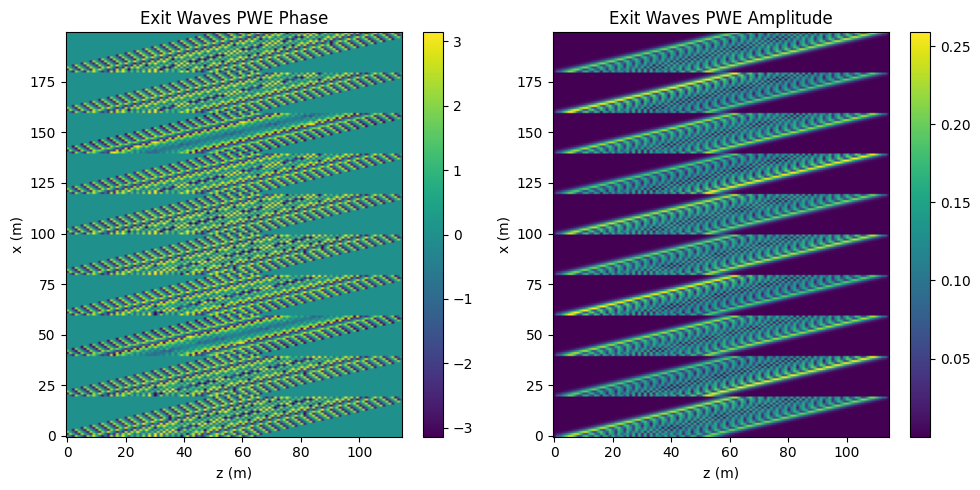

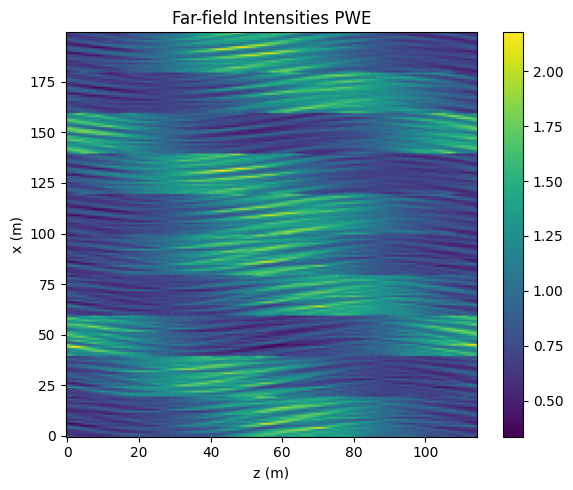

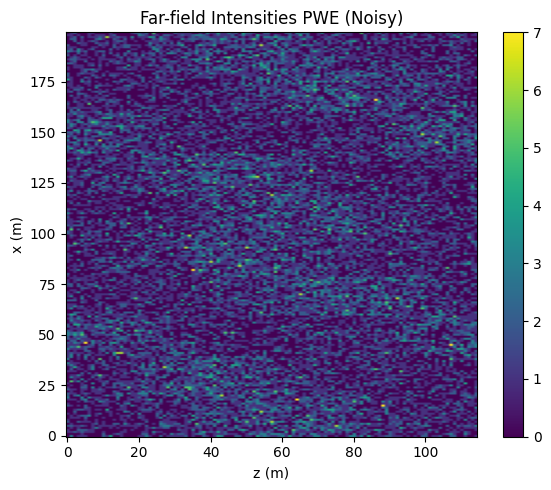

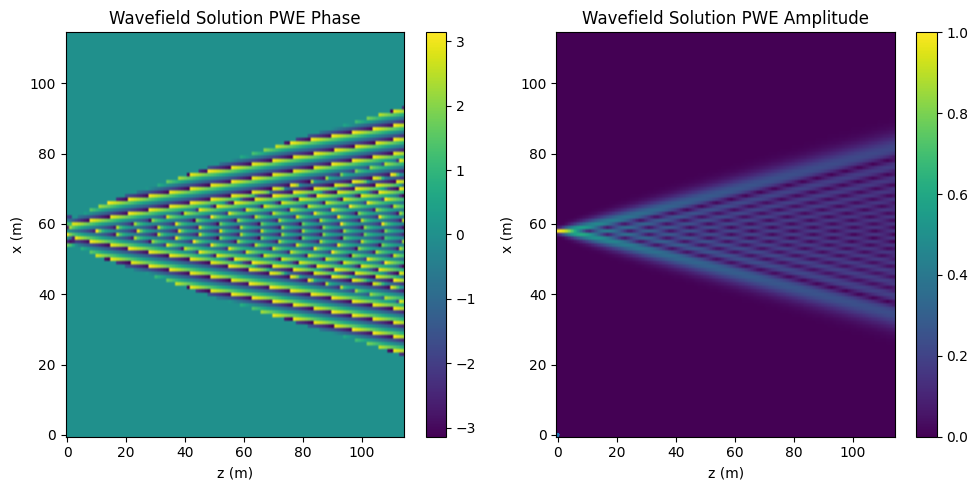

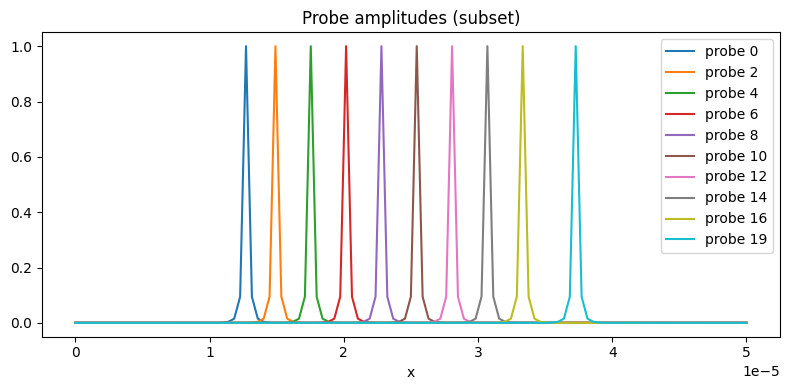

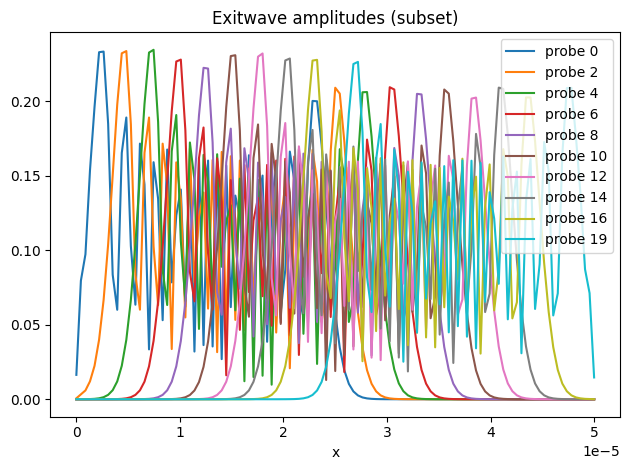

In [5]:
simulation_space.viewer.plot_two_panels(exit_waves_pwe,
                                        view="phase_amp", 
                                        title="Exit Waves PWE",
                                        xlabel="z (m)",
                                        ylabel="x (m)")

simulation_space.viewer.plot_single_panel(intensities_pwe,
                                        title="Far-field Intensities PWE",
                                        xlabel="z (m)",
                                        ylabel="x (m)")

simulation_space.viewer.plot_single_panel(intensities_pwe_noisy,
                                        title="Far-field Intensities PWE (Noisy)",
                                        xlabel="z (m)",
                                        ylabel="x (m)")

# Select Centre Probe
centre_probe_pwe = u_pwe[0,0,simulation_space.num_probes//2, ...]
simulation_space.viewer.plot_two_panels(centre_probe_pwe,
                                        view="phase_amp", 
                                        title="Wavefield Solution PWE",
                                        xlabel="z (m)",
                                        ylabel="x (m)")

plt.plot(simulation_space.x, centre_probe_pwe[:, nz//2])
plt.show()

plt.figure(figsize=(8,4))
plot_num_probes = 10#simulation_space.num_probes
probe_indices = np.linspace(0, simulation_space.num_probes-1, plot_num_probes, dtype=int)
for p in probe_indices:
    plt.plot(simulation_space.x, np.abs(u_pwe[0,0,p,:,0]), label=f'probe {p}')
plt.title("Probe amplitudes (subset)")
plt.xlabel("x"); plt.legend(); 
plt.tight_layout(); plt.show()

for p in probe_indices:
    plt.plot(simulation_space.x, np.abs(u_pwe[0,0,p,:,-1]), label=f'probe {p}')
plt.title("Exitwave amplitudes (subset)")
plt.xlabel("x"); plt.legend(); 
plt.tight_layout(); plt.show()


### 6. Inverse Problem Assuming Phase
The exit wave of the forward solution can be set as the initial condition for
the system to be solved in reverse. 

In [6]:
# --- Reconstruction data ---
complex_data = exit_waves_pwe

In [7]:
# Create MS Simulation Space
dz = wavelength * 16 # For multi-slice, keep dz larger to reduce number of slices
nz = int(z_range / dz)
discrete_dimensions = (int(min_nx * pad_factor), nz)

# --- Create the SimulationConfig object ---
config_ms = SimulationConfig(
    continuous_dimensions=continuous_dimensions,
    discrete_dimensions=discrete_dimensions,
    probe_dimensions=probe_dimensions_discrete,
    scan_points=scan_points,
    step_size=step_size,
    bc_type=bc_type,
    probe_type=probe_type,
    wave_number=k0,
    probe_diameter_scale=probe_diameter_scale,
    probe_focus=probe_focus,
    tomographic_projection_90_degree=False,
    thin_sample=False,
    n_medium=n_medium,
    results_dir="./results",
    use_logging=True
)
simulation_space_ms = create_simulation_space(config_ms)
simulation_space_ms.summarize()


2025-10-29 17:20:44,738 - INFO - === Scan Summary (Continuous) ===
2025-10-29 17:20:44,740 - INFO -   Sample space (x-range): 5.000e-05 m
2025-10-29 17:20:44,741 - INFO -   Sample space (z-range): 5.000e-05 m
2025-10-29 17:20:44,742 - INFO -   Probe diameter:         1.000e-06 m
2025-10-29 17:20:44,743 - INFO -   Number of scan points:  20
2025-10-29 17:20:44,744 - INFO -   Steps in z:             4
2025-10-29 17:20:44,745 - INFO -   Detector Pixels:        115
2025-10-29 17:20:44,746 - INFO -   Max Overlap:            -3.158e-07 m
2025-10-29 17:20:44,748 - INFO -   Percentage Overlap:     -72000000.00%



Initialized Multislice 3PIE Reconstructor.
[Iter 001] Mean Loss = 12.384164098115175
[Iter 002] Mean Loss = 12.371532107668003
[Iter 003] Mean Loss = 12.364621419787825
[Iter 004] Mean Loss = 12.359815631135818
[Iter 005] Mean Loss = 12.356121716578501
[Iter 006] Mean Loss = 12.353118724039865
[Iter 007] Mean Loss = 12.350587690580022
[Iter 008] Mean Loss = 12.348399854165027
[Iter 009] Mean Loss = 12.346472967568515
[Iter 010] Mean Loss = 12.344751254179336


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residual History'}, xlabel='Iteration', ylabel='RMSE'>)

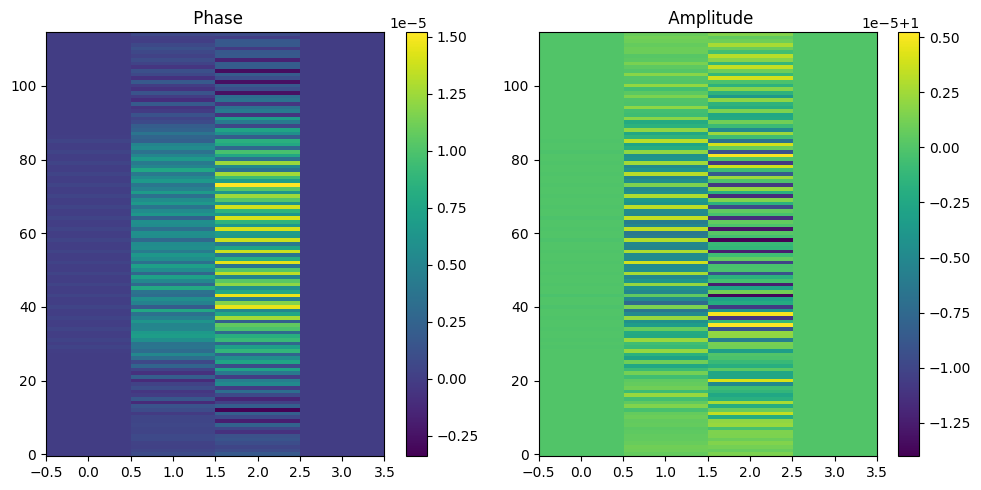

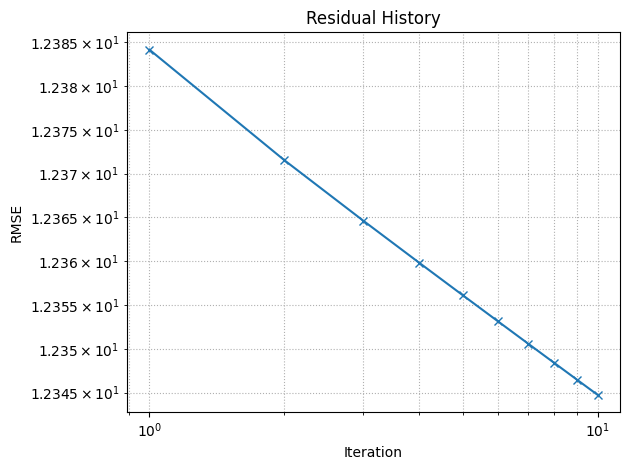

In [8]:
recon_ms = ReconstructorMS(simulation_space_ms, complex_data.squeeze(), phase_retrieval=False, verbose=True)
n_est_ms, residual_ms = recon_ms.reconstruct(max_iters=10,alpha_obj=1e-4)
simulation_space_ms.viewer.plot_two_panels(n_est_ms,view="phase_amp")
simulation_space_ms.viewer.plot_residual(residual_ms)

Initializing Least Squares Solver...
Iteration 1/2
    RMSE: 0.01713718522993173
    Iteration 1 took 12.31 seconds.
Iteration 2/2
    RMSE: 0.011060969249618044
    Iteration 2 took 13.38 seconds.


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residual History'}, xlabel='Iteration', ylabel='RMSE'>)

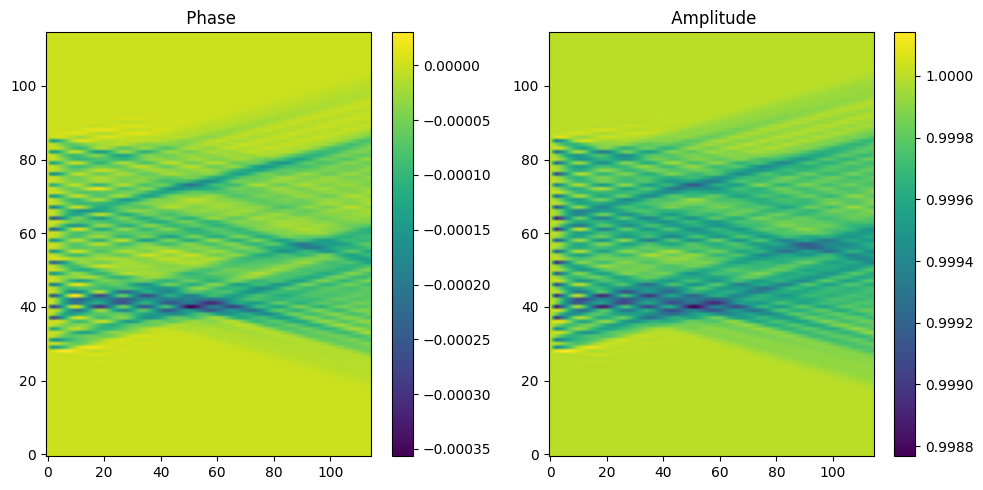

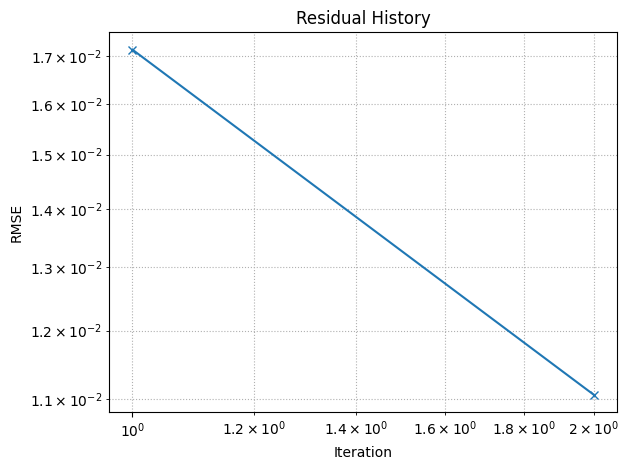

In [9]:
recon_pwe = ReconstructorPWE(simulation_space, complex_data, phase_retrieval=False, verbose=True)
n_est_pwe, recon_u_pwe, residual_pwe = recon_pwe.reconstruct(max_iters=2)
simulation_space.viewer.plot_two_panels(n_est_pwe,view="phase_amp")
simulation_space.viewer.plot_residual(residual_pwe)

## Phase Retrieval

In [10]:
# --- Reconstruction data ---
data = intensities_pwe

Initialized Multislice 3PIE Reconstructor.
[Iter 001] Mean Loss = 0.07294510944727771
[Iter 002] Mean Loss = 0.07287103430695885
[Iter 003] Mean Loss = 0.07283099567062332
[Iter 004] Mean Loss = 0.07280330490102617
[Iter 005] Mean Loss = 0.07278208881553946
[Iter 006] Mean Loss = 0.0727648777137078
[Iter 007] Mean Loss = 0.07275039374911531
[Iter 008] Mean Loss = 0.07273788831093919
[Iter 009] Mean Loss = 0.07272688457439158
[Iter 010] Mean Loss = 0.07271705989111349


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residual History'}, xlabel='Iteration', ylabel='RMSE'>)

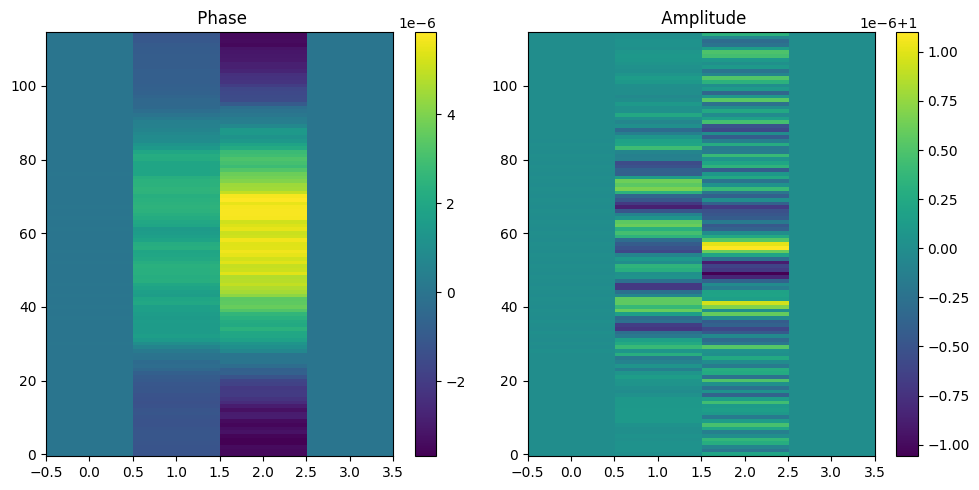

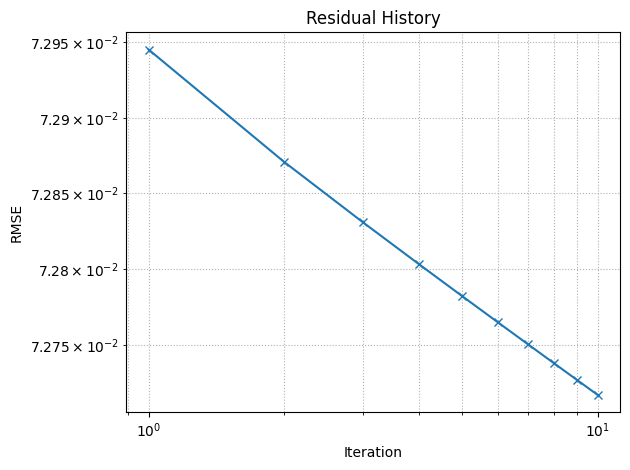

In [ ]:

recon_ms = ReconstructorMS(simulation_space_ms, data, phase_retrieval=True, verbose=True)
n_est_ms, residual_ms = recon_ms.reconstruct(max_iters=10,alpha_obj=1e-4)
simulation_space_ms.viewer.plot_two_panels(n_est_ms,view="phase_amp")
simulation_space_ms.viewer.plot_residual(residual_ms)

In [ ]:
recon_pwe = ReconstructorPWE(simulation_space, data, phase_retrieval=True, verbose=True)
n_est_pwe, recon_u_pwe, residual_pwe = recon_pwe.reconstruct(max_iters=3)
simulation_space.viewer.plot_two_panels(n_est_pwe,view="phase_amp")
simulation_space.viewer.plot_residual(residual_pwe)

Initializing Least Squares Solver...
Iteration 1/3
    RMSE: 0.007073420064228453
    Iteration 1 took 14.41 seconds.
Iteration 2/3
    RMSE: 0.0061539633867766595
    Iteration 2 took 12.61 seconds.
